# Script Purpose

This script begins by simulating the correlation for a monochromatic wave. We then use a set of superposed cosines for a fixed phase center and varying theta. We run the sim through varying baselines as well see signal attenuation. 


# Signal Generation

In order to generate a signal, we need to decide on a sample size. The samplesize for the actual array takes into consideration different bandwidths, channel widths, downconversion rates for the various antenna configurations and a center frequency. This script uses a model based only on the baseline length between two given antennas to calculate the samplize. We multiply an oversampling factor, $O$ to minimize distortions that may otherwise be present during sampling.


## Defining Sample Size

The geometric delay is baseline/c. (b.s/c). 

The number of samples for geometric delay = Sampling Freq * b/c 

$$ \mathrm{Samplesize} =  2 * O * F_{obs} * \frac{b}{c} + 1/CW + dt * step  $$

where 

$F_{obs}$ = Center Frequency Observed 

CW = Channel Width

dt * step = Integration time

c = speed of light
      
b = baseline length

O = Oversampling factor

The factor 2 is to cover the nyquist rate.

### Sampling rate

The 'dt' can be derived by using b.s/c/samplesize and in this way we can make it independent of the center frequency. However, it can also be expressed as $\frac{1}{(O * F_{obs})}$

We also generate 'actual samplesize' which is larger than the samplesize calculated to incude the array shifting for real and imaginary channels. That is done by multiplying another factor to the samplesize.
      


In [ ]:
%run -i RFI_write_up_clean_copy.py

In [ ]:
#F_observed needs to be many factors less than the Bandwidth to produce a larger samplesize.
F_obs = 1e6#in Hz
b = 10000#meters
step = 100
CW = 1e4
o_fact = 2500# Oversampling Factor 
samplesize,dt,actual = sample_calc(CW,F_obs, b,o_fact,step)
print('Samplesize', samplesize)

## Signal

### Monochromatic

The radio waves in nature are in form of sines and cosines. 

dt = 1/Bandwidth

The samplesize points are separated by length dt.

The signal is then expressed as $$\cos(2 * pi * [s] * dt * F_{obs})$$
where [s] * dt is the time array
and $F_{obs}$ is the center frequency.

The units of cosine are in radians.

For the following cell generates signals with two unique frequencies- $F_{obs}$ abd F2. The parameters- Bandwidth, baseline and oversampling factors are generated in the previous cell. 

In [ ]:
#cell before this needs to be run to initialize parameters
Sig,Time = sig_gen( F_obs, b, dt, actual)

In [ ]:
#generating a second signal 10 Mhz away from the first frequency F_obs
F2 = 1e6 + F_obs 
Sig2, Time2 = sig_gen( F2, b, dt, actual)

In [ ]:
plt.plot(Time,Sig,'o')
plt.plot(Time2,Sig2,'r')
plt.title('Single Frequency Signals')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend(['F_obs','F2'])
plt.xlim(0,0.0001)
plt.show()

# Total Delay for any geostationary RFI or equivalent

Given two antennas and a phase center as shown in the figure below:


<img src="files/D_tdiagram.jpg" style="width: 500px;">



The following are the delays and projected baselines for the above symmetry:

$$D_{phc}= B \cos\theta$$


$$D_{RFI} = B \cos\phi $$


where,

$D_{phc}$ = Phase center delay length 

$D_{RFI}$ = RFI delay length

Given an angle for the source and an angle for a source of interference, the total phase delay would become(from Thompson 1982):

$$D_t = \frac{B  * |\cos\theta - \cos\phi| * F_{obs} * 2 *\pi}{c}$$

where 

D_t = total phase delay in units of radians.

B = baseline length

$\theta $ = Source center or Phase Center

$\phi $ = Radio Frequency Interference Source
      
c = speed of light 
      
$F_{obs}$ = Center Frequency Observed 

We can run this delay as a function of theta or as a function of 
baseline given a fixed theta. That is what the cell below shows. 


In [ ]:
#this cell can be run independently
%run -i RFI_write_up_clean_copy.py


F_obs_c = 1e8#in Hz
theta_c = 10
phi_c =np.arange(0 ,90,3)
baselines_in = 100#np.arange(0,300,50)
D_t = tot_phase(F_obs_c, baselines_in,phi_c, theta_c)

plt.plot(phi_c,D_t,'o')
plt.xlabel('Baselines(m)')
plt.ylabel('Total Phase Delay(deg)')
plt.legend(['Baselines vs Total Phase Delay(deg)'])
plt.show()



# Calculating the number of shifted samples

In this case, instead of $\theta$, we use the total phase delay function, $D_t$ to acount for the geometric delay due to the baselines also.  


$$\lambda  = \frac{c}{F_{obs}}$$

Fraction of wavelength shifted for a given total phase delay $D_t$:

$$\lambda_{frac} = \frac{D_t}{2\pi}$$

Samples to shift:

$$\mathrm{tshift} = \frac{D_t}{2\pi} * \frac{\lambda}{c * dt} $$

where

$\mathrm{tshift}$ = Number of samples required to shift the wave by the phase $D_t$

$D_t$ = Total phase delay betwween antennas

c = speed of light 

dt = $\frac{1}{Bandwidth}$


tshift is unitless.

Samples to shift for imaginary magnitude:
$$\mathrm{tshift} = \frac{D_t + 90}{2\pi} * \frac{\lambda}{c * dt} $$





In [ ]:
%run -i RFI_write_up_clean_copy.py

#the first few cells need to be sun before this one 

F_obs = 1e8#in Hz
phi1 = 30
theta = 0
tshift, imtshift= tshift_calc(Sig, F_obs, b, phi1,theta ,dt)
print(tshift)
print(imtshift)

# Correlation of Waves

The correlator function needs three types of wave inputs to output visibility function :
- An imaginary magnitude of the visibility function is created by correlating the wave with phase shift 90 deg + $\theta$ and the original wave with no phase shift. 
- A real magnitude of the visibility function is created by correlating the wave with phase shift $\theta$ and original wave with no phase shift.

The real and imaginary channels are multiplied and accumulated to give a mean amplitude value from the two channels. Those values are then combined to get a complex visibility amplitude and the arctan of the two values gives us back the phase delay or the total phase delay in our case. 

The following cell runs through the single frequency case as well as the superposition of two frequencies case and gets back the recovered delay. There were discrepancies in the recovered delay value for loops beyond 180 deg so we use the formula below in the 'recov_b' or recovered phase to recovered the initial phase offset we input. 

In [ ]:
# to see what the np.angle does to total phase delay > 180 

recov2 = []
recov = [] 
Dts = []
amp = []

 
recov2_f2 = []
recov_f2 = []
Dts_f2 = []
amp_f2 = []
 


begin = -360 # units in degrees
end = 360
inter = 30
theta = 0

for phi2 in np.arange(begin,end,inter):
    D_t = tot_phase(F_obs, b, phi2, theta)
    D_t_f2 = tot_phase(F2, b, phi2, theta)

 
    tshift,imtshift = tshift_calc(Sig, F_obs, b, phi2 ,theta,dt)
    tshift2,imtshift2 = tshift_calc(Sig2, F2, b, phi2 ,theta,dt)


    orig,real, im = shift_sigs(Sig,samplesize, tshift,imtshift,actual)
    orig2,real2, im2 = shift_sigs(Sig2,samplesize, tshift2,imtshift2,actual)

#plt.plot(orig)
#plt.plot(real,'r')
#plt.plot(im,'g')
#plt.xlim(0,200)
#plt.legend(['Original','Real','Imaginary'])
#plt.show()


    step = 200
    meanr, meani, complexvis= correlate(orig,real,im,step,F_obs,samplesize)
    meanr2, meani2, complexvis2= correlate(orig2,real2,im2,step,F2,samplesize)

    
    recov_angle = np.angle(meanr-meani*1j, deg=True)
    recov_angle_f2 = np.angle(meanr2-meani2*1j, deg=True)


    recov_b =  D_t - (360 * np.round( D_t/360))
    recov_b_f2 =  D_t_f2 - (360 * np.round( D_t_f2/360))


    recov2.append(recov_b)
    recov2_f2.append(recov_b_f2)


    recov.append(recov_angle)
    recov_f2.append(recov_angle_f2)


    Dts.append(D_t)
    Dts_f2.append(D_t_f2)


    amp.append(np.abs(complexvis))
    amp_f2.append(np.abs(complexvis2))


#print('The angle recovered back using the real and imaginary magnitude',np.angle(complexvis,deg = True))
#print(meanr)
#print(meani)
#print(np.angle(meanr+meani*1j, deg=True))

accuracy_phase = dt * F_obs * 360.0 


print('Total Phase Delay(deg) =',Dts)
print('Recovered Phase delay(deg) = ', recov)
print('---------------------------------------')
print('Recovered by force =', recov2)
#print('Difference = ',abs(np.array(Dts))- abs(np.array(recov)))
print('---------------------------------------')
#print('Theta(deg) = ',np.arange(begin,end,inter))
#print('Total phase delay - accuracy factor =', np.array(Dts) - accuracy_phase)




In [ ]:
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)
ax1.plot(Dts, recov,'ro-')
ax1.title.set_text('Single Frequency:D_t vs Recovered D_t')
ax2 = fig.add_subplot(2,2,2)
ax2.plot(Dts,recov2,'r-')
ax2.title.set_text('Double Frequency:D_t vs Recovered D_t')
ax3 = fig.add_subplot(2,2,3)
ax3.plot(Dts,amp,'o')
ax3.title.set_text('Single Frequency:D_t vs Amplitude')
ax4 = fig.add_subplot(2,2,4)
ax4.plot(Dts_f2,amp_f2)
ax4.title.set_text('DoubleFrequency:D_t vs Amplitude')
plt.show()



print('The offset factor for single frequency case = ',np.mean(abs(np.array(recov2)-np.array(recov))))
#V_avg = 2*V_p/pi, where V_p is peak voltage
A = 1 # the amplitude for our cosines
print('the theoretical power of a sine wave is', (A**2)/2 )
print('The offset factor for double frequency case = ',np.mean(abs(np.array(recov2_f2)-np.array(recov_f2))))



# Generating Superposed Waves

Next, we generate superposed cosines by selecting a range of frequencies and adding all of them togehter. The cell below generates such a signal.

In [ ]:
%run -i RFI_write_up_clean_copy.py


#Generating multiple signals
F_obs = 1e8#in Hz
b = 100 #meters
F_delta = 1e3
o_fact= 250
step = 100
Fend = 10e6 + F_obs
SigB,time3,samplesize2,dt2,actual2 = mul_sig_gen( F_obs,Fend,F_delta, b,o_fact,step)


plt.plot(time3,SigB,'r')
plt.title('Superposed Cosines')
plt.xlabel('time')
plt.ylabel('Amplitude')
plt.show()

# Theoretical Sinc

Thompson equation 2.4 gives us the theoretical formula for antennas just phased upto some coordinate:

$$\cos(\frac{b* \sin\theta * 2 *\pi* v_o}{c}) * \frac{\sin(\frac{b* \sin\theta *\pi* \delta v}{c})}{\frac{b *\pi* \delta v}{c}}$$

where 

b = baseline length

$\theta $ = phase delay between the two antennas 
      
c = speed of light 
      
$v_o$ = Center Frequency Observed 

$\delta v$ = Channel Width 


For the RFI case or a case where you have an RFI some degrees away from where the telescope is phased up:


$$\cos(\frac{b* \cos\theta * \sin\phi * 2 *\pi}{c}) * \frac{\sin(\frac{b* \sin\phi *\pi* \delta v}{c})}{\frac{b *\pi* \delta v}{c}}$$

where 

b = baseline length

$\theta $ = phase delay between the two antennas 
      
c = speed of light 
      
$v_o$ = Center Frequency Observed 

$\delta v$ = Channel Width 




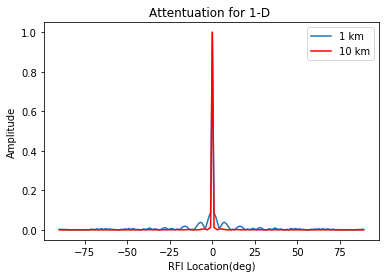

In [30]:
%run -i RFI_write_up_clean_copy.py


F_obs = 1e6#in Hz
b = 1000 #np.arange(1,3560,100) #in meters
b2 = 10000
F_del = 5e6
o_fact= 250
F_end = 200e6 + F_obs
theta = 0
phi = np.arange(-90,90,1)

in_theory =  sinc_theory_rfi(b,theta,F_del,F_obs,phi )
in_theory2 =  sinc_theory_rfi(b2,theta,F_del,F_obs,phi )


plt.plot(phi,in_theory)
plt.plot(phi,in_theory2,'r')
plt.title('Attentuation for 1-D ')
plt.xlabel('RFI Location(deg)')
plt.ylabel('Amplitude')
plt.legend(['1 km','10 km'])
plt.show()

# Plots

## Varying Phase
The following cell goes through different phases and plots the phase recovered vs original input and the amplitude vs original phase input.

In [27]:
%run -i RFI_write_up_clean_copy.py


#This cell can run independently. 


step1 = 5000
phinterval = 4
startphi = -90
endphi = 90

F_obs_1 = 30e6#in Hz
b1 = 250 #meters

F_end = 10e6 + F_obs_1 #in Hz
F_del = 1e6 #in Hz, not below this. 
o_fact = 250
theta = 0

F_center = (F_obs_1+F_end)/2

#to run a multi-loop 
Sig_mult,Time,samplesize,dt,actual =  mul_sig_gen( F_center,F_end,F_del, b1,o_fact,step1)
phi_input,phasestored, amplitude, D_t_store = loop(samplesize, F_center,step1, phinterval,startphi,endphi,b1,Sig_mult,dt,actual,theta)

p = np.arange(startphi,endphi,phinterval)
amp_calc= sinc_theory(b1,phi_input,F_del,F_obs_1)


dt 1.1428571428571429e-10 s
actual samplesize 291660
Integration Time(s) 5.714285714285715e-07


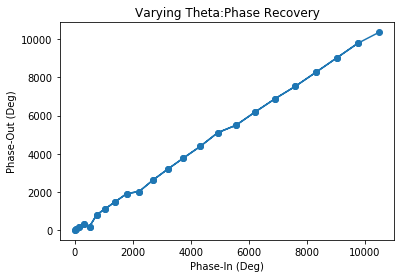

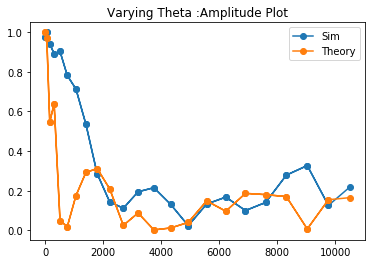

In [28]:
plt.plot(D_t_store,phasestored,'o-')
plt.title('Varying Theta:Phase Recovery')
plt.xlabel('Phase-In (Deg)')
plt.ylabel('Phase-Out (Deg)')
#plt.ylim(2000,-2000)
plt.show()

plt.plot(D_t_store,amplitude/np.max(amplitude),'o-')
plt.plot(D_t_store,amp_calc/np.max(amp_calc),'o-')
#plt.xlim(-4000,4000)
plt.title('Varying Theta :Amplitude Plot')
plt.legend(['Sim','Theory'])
plt.show()



## Varying Baseline

The following cells produce plots for changing baselines for two different theta along with their respective theoretical predications. 


In [3]:
%run -i RFI_write_up_clean_copy.py

#Same initial parameters as above
step1 = 200
F_obs_1 = 100e6#in Hz
F_end = 10e6 + F_obs_1 #in Hz
F_del2 = 1e6 #in Hz, not below this. 
o_fact = 350
#new parameters
start_b=-255
end_b= 255.0 #range of baselines 1-255 m.
theta= 0

interval_b=1 #in m
phi2 = 90.0 #deg

#Generating loops 
ph2,am2,totph2,base2 = loop_base( F_obs_1,step1,start_b,end_b, interval_b,phi2,theta,F_end,F_del2,o_fact)


dt 2.8571428571428573e-11 s
actual samplesize 1190000
Integration Time(s) 5.714285714285714e-09
Coherence Time 1e-06
dt 2.8571428571428573e-11 s
actual samplesize 1190000
Integration Time(s) 5.714285714285714e-09
Coherence Time 1e-06


In [7]:
#Generating Theoretical Predictions for the tho angles
amp_theory2 = sinc_theory((base2),phi2,F_del,F_obs_1)

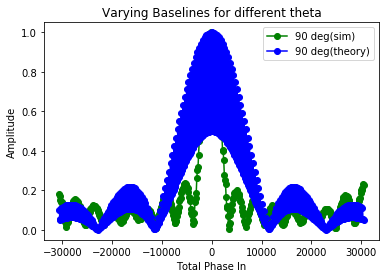

In [12]:

plt.plot(totph2,am2/np.max(am2),'go-')
plt.plot(totph2,amp_theory2/np.max(amp_theory2),'bo-')
plt.title('Varying Baselines for different theta')
plt.xlabel('Total Phase In')
plt.ylabel('Amplitude')
#plt.xlim(-30,30)
#plt.ylim(0,0.06)
plt.legend(['90 deg(sim)','90 deg(theory)'])
plt.show()

#plt.plot(totph,ph/np.max(ph),'ro-')
#plt.plot(totph2,ph2/np.max(ph2),'go-')
#plt.title('Phase Recovery Plot')
#plt.show()